In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import pickle
import matplotlib
import matplotlib.pyplot as plt
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.utils.class_weight import compute_class_weight
import itertools
from IPython.display import display

%matplotlib inline

In [2]:
x_train = pd.read_csv('../input/audio-dataset/audio_train.csv')
x_test = pd.read_csv('../input/audio-dataset/audio_test.csv')

print(x_train.shape)
y_train = x_train['label']
y_test = x_test['label']

(7837, 13)


In [3]:
print(x_train.shape, x_test.shape)
cl_weight = dict(pd.Series(x_train['label']).value_counts(normalize=True))
print(dict(pd.Series(x_train['label']).value_counts()))

del x_train['label']
del x_test['label']
del x_train['wav_file']
del x_test['wav_file']

(7837, 13) (1960, 13)
{2: 2335, 5: 1379, 1: 1322, 3: 977, 4: 953, 0: 871}


In [4]:
emotion_dict = {'ang': 0,
                'hap': 1,
                'sad': 2,
                'fea': 3,
                'sur': 4,
                'neu': 5}

emo_keys = list(['ang', 'hap', 'sad', 'fea', 'sur', 'neu'])

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels = np.zeros((num_records, num_classes))
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

def display_results(y_test, pred_probs, cm=True):
    pred = np.argmax(pred_probs, axis=-1)
    one_hot_true = one_hot_encoder(y_test, len(pred), len(emotion_dict))
    print('Test Set Accuracy =  {0:.3f}'.format(accuracy_score(y_test, pred)))
    print('Test Set F-score =  {0:.3f}'.format(f1_score(y_test, pred, average='macro')))
    print('Test Set Precision =  {0:.3f}'.format(precision_score(y_test, pred, average='macro')))
    print('Test Set Recall =  {0:.3f}'.format(recall_score(y_test, pred, average='macro')))
    if cm:
        plot_confusion_matrix(confusion_matrix(y_test, pred), classes=emo_keys)

Test Set Accuracy =  0.631
Test Set F-score =  0.640
Test Set Precision =  0.668
Test Set Recall =  0.634
Confusion matrix, without normalization
[[ 91  30  97   0   3  11]
 [ 24 113 137   0   0  40]
 [ 32  50 444   1   5  66]
 [  0   0   0 263   0   0]
 [  0   0   0   0 224   0]
 [  8  37 178   1   3 102]]


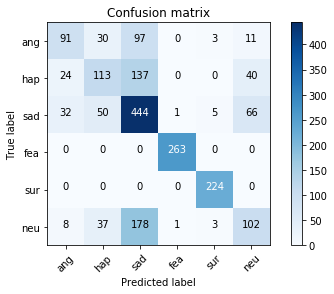

In [5]:
rf_classifier = RandomForestClassifier(n_estimators=1200, min_samples_split=25)
rf_classifier.fit(x_train, y_train)

# Predict
pred_probs = rf_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('rf_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

Test Set Accuracy =  0.633
Test Set F-score =  0.652
Test Set Precision =  0.665
Test Set Recall =  0.646
Confusion matrix, without normalization
[[ 98  29  83   0   1  21]
 [ 26 119 113   1   0  55]
 [ 43  56 406   2   1  90]
 [  0   0   0 263   0   0]
 [  0   0   0   0 224   0]
 [ 15  36 145   1   1 131]]


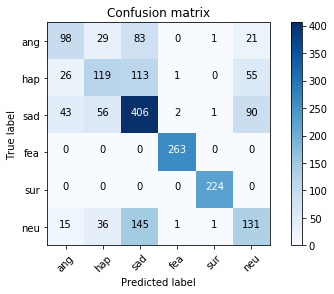

In [6]:
xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.008, objective='multi:softprob', 
                                   n_estimators=1200, sub_sample=0.8, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(x_train, y_train)

# Predict
pred_probs = xgb_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('xgb_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

Test Set Accuracy =  0.568
Test Set F-score =  0.571
Test Set Precision =  0.593
Test Set Recall =  0.569
Confusion matrix, without normalization
[[ 91  30  81   6  13  11]
 [ 13 115 119   9  17  41]
 [ 27  53 385  10  36  87]
 [  0   0   0 263   0   0]
 [  0   6  49   0 156  13]
 [  8  37 151  11  18 104]]


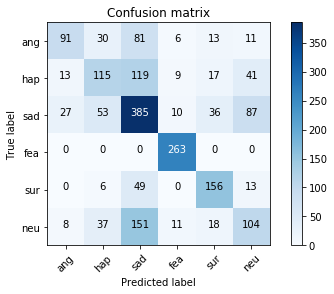

In [7]:
mlp_classifier = MLPClassifier(hidden_layer_sizes=(650, ), activation='relu', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='adaptive', learning_rate_init=0.01,
                               power_t=0.5, max_iter=1000, shuffle=True, random_state=None, tol=0.0001,
                               verbose=False, warm_start=True, momentum=0.8, nesterovs_momentum=True,
                               early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999,
                               epsilon=1e-08)

mlp_classifier.fit(x_train, y_train)

# Predict
pred_probs = mlp_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('mlp_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

Test Set Accuracy =  0.568
Test Set F-score =  0.571
Test Set Precision =  0.593
Test Set Recall =  0.569
Confusion matrix, without normalization
[[ 91  30  81   6  13  11]
 [ 13 115 119   9  17  41]
 [ 27  53 385  10  36  87]
 [  0   0   0 263   0   0]
 [  0   6  49   0 156  13]
 [  8  37 151  11  18 104]]


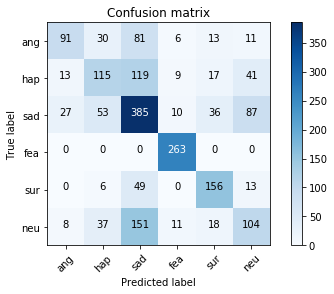

In [8]:
svc_classifier = LinearSVC()

svc_classifier.fit(x_train, y_train)

# Predict
pred = svc_classifier.predict(x_test)

# Results
display_results(y_test, pred_probs)

with open('svc_classifier_model.pkl', 'wb') as f:
    pickle.dump(svc_classifier, f)

Test Set Accuracy =  0.312
Test Set F-score =  0.098
Test Set Precision =  0.144
Test Set Recall =  0.177
Confusion matrix, without normalization
[[ 15   0 217   0   0   0]
 [  8   0 306   0   0   0]
 [  1   0 597   0   0   0]
 [  0   0 263   0   0   0]
 [  2   0 222   0   0   0]
 [  1   0 328   0   0   0]]


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


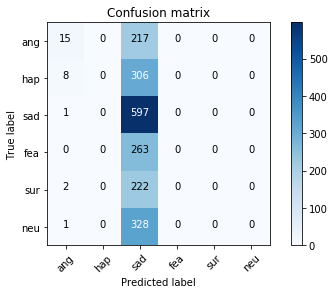

In [9]:
mnb_classifier = MultinomialNB()

mnb_classifier.fit(x_train, y_train)

# Predict
pred_probs = mnb_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('mnb_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

Test Set Accuracy =  0.374
Test Set F-score =  0.283
Test Set Precision =  0.404
Test Set Recall =  0.289
Confusion matrix, without normalization
[[ 87  27 109   2   6   1]
 [ 24  85 179  17   0   9]
 [ 22  52 485   9   9  21]
 [  0  20 178  34   0  31]
 [ 12  20 155  12  15  10]
 [  7  24 253  16   2  27]]


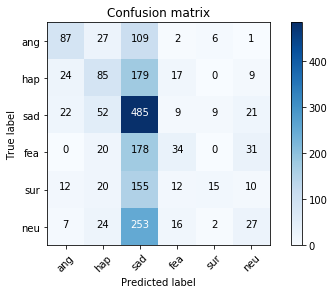

In [10]:
lr_classifier = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000)

lr_classifier.fit(x_train, y_train)

# Predict
pred_probs = lr_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('lr_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

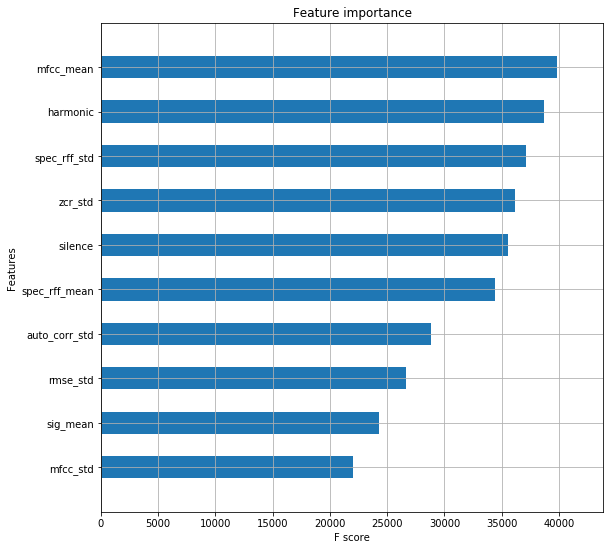

In [11]:
ax = xgb.plot_importance(xgb_classifier, max_num_features=10, height=0.5, show_values=False)
fig = ax.figure
fig.set_size_inches(9, 9)

In [12]:
contribution_scores = xgb_classifier.feature_importances_


In [13]:
top_n = [3, 5, 6, 7, 8]  # number of features
for n in top_n:
    threshold = np.argsort(contribution_scores)[::-1][:n][-1]
    print('Stats for top {} features:'.format(n))
    # Select features using threshold
    selection = SelectFromModel(xgb_classifier, threshold=contribution_scores[threshold], prefit=True)
    select_x_train = selection.transform(x_train)
    select_x_test = selection.transform(x_test)
    
    # Train
    select_xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.008, objective='multi:softprob', 
                                              n_estimators=1200, sub_sample = 0.8, num_class = len(emotion_dict),
                                              booster='gbtree', n_jobs=4)
    select_xgb_classifier.fit(select_x_train, y_train)

    # Predict
    pred_probs = select_xgb_classifier.predict_proba(select_x_test)

    # Results
    display_results(y_test, pred_probs, cm = False)

Stats for top 3 features:
Test Set Accuracy =  0.582
Test Set F-score =  0.595
Test Set Precision =  0.608
Test Set Recall =  0.596
Stats for top 5 features:
Test Set Accuracy =  0.614
Test Set F-score =  0.627
Test Set Precision =  0.641
Test Set Recall =  0.625
Stats for top 6 features:
Test Set Accuracy =  0.604
Test Set F-score =  0.617
Test Set Precision =  0.627
Test Set Recall =  0.617
Stats for top 7 features:
Test Set Accuracy =  0.623
Test Set F-score =  0.636
Test Set Precision =  0.650
Test Set Recall =  0.634
Stats for top 8 features:
Test Set Accuracy =  0.618
Test Set F-score =  0.633
Test Set Precision =  0.644
Test Set Recall =  0.631


Test Set Accuracy =  0.642
Test Set F-score =  0.651
Test Set Precision =  0.674
Test Set Recall =  0.648
Confusion matrix, without normalization
[[ 94  26  93   3   4  12]
 [ 23 126 123   1   2  39]
 [ 29  51 436   4  11  67]
 [  0   0   0 263   0   0]
 [  0   0   0   0 224   0]
 [  8  35 164   2   5 115]]


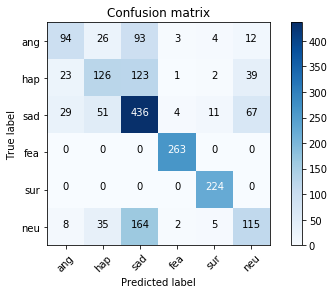

In [14]:
# Load predicted probabilities
# Load predicted probabilities
with open('rf_classifier.pkl', 'rb') as f:
    rf_pred_probs = pickle.load(f)

with open('xgb_classifier.pkl', 'rb') as f:
    xgb_pred_probs = pickle.load(f)
    
with open('svc_classifier_model.pkl', 'rb') as f:
    svc_preds = pickle.load(f)
    
with open('mnb_classifier.pkl', 'rb') as f:
    mnb_pred_probs = pickle.load(f)
    
with open('mlp_classifier.pkl', 'rb') as f:
    mlp_pred_probs = pickle.load(f)
    
with open('lr_classifier.pkl', 'rb') as f:
    lr_pred_probs = pickle.load(f)

#with open('data/pred_probas/lstm_classifier.pkl', 'rb') as f:
#    lstm_pred_probs = pickle.load(f)

# Average of the predicted probabilites
ensemble_pred_probs = (xgb_pred_probs +
                       mlp_pred_probs +
                       rf_pred_probs)/3.0
# Show metrics
display_results(y_test, ensemble_pred_probs)